# Finding low-surface brightness galaxies in the S-PLUS survey

The detection of low surface brightness galaxies (LSBGs) in imaging surveys is problematic due to the lack of depth, and current instrumentation and pipelines that are not focused on these types of objects. This project aims to use innovative machine learning techniques to automatically detect LSBGs in the S-PLUS survey, thus increasing their number and providing interesting candidates for spectroscopic follow-up. Such techniques can be applied both in catalogs and images, and expanded to future surveys such as that of the Vera Rubin Telescope. 

In [2]:
from astroML.utils import split_samples
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 
import numpy as np 
from astropy.table import Table
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif", 
    "font.serif": ["Palatino"], # latex font
    'font.size': 20}) 

In [3]:
data = Table.read('./LSBs_Red_Nothing.fits',format='fits') # import the data that will be splitted in training and test samples.

attributes = [('g','r','A','FWHM','KRON_RADIUS','MU_MAX')] 
# key physical parameters that will be used as features since they separatr well the objects. 
#From those, we pay a special attention to the magnitudes, surface brightness and kron_radius, since LSBs are generally fainter than other galaxies and larger in radii.
# The KRON_RADIUS, defined as the first moment of the surface brightness light profile is strongly correlated with redshift and thus may provide a good difference among sources.
A = data['A']
g = data['G_auto']
r = data['R_auto']
FWHM = data['FWHM_n']
KRON_RADIUS = data['KRON_RADIUS']
MU_MAX = data['MU_MAX']
labels = data['Type'] # divided in 0 (LSBs), 1 (red/high-reshift) and 2 (nothing)

In [4]:
symbcolor = np.full(np.size(labels), 'magenta')
symbcolor[labels == 0] = 'red' # bonafide LSBs
symbcolor[labels == 1] = 'blue' # compact, red and most likely high-redshift objects
symbcolor[labels == 2] = 'green' # None of the above


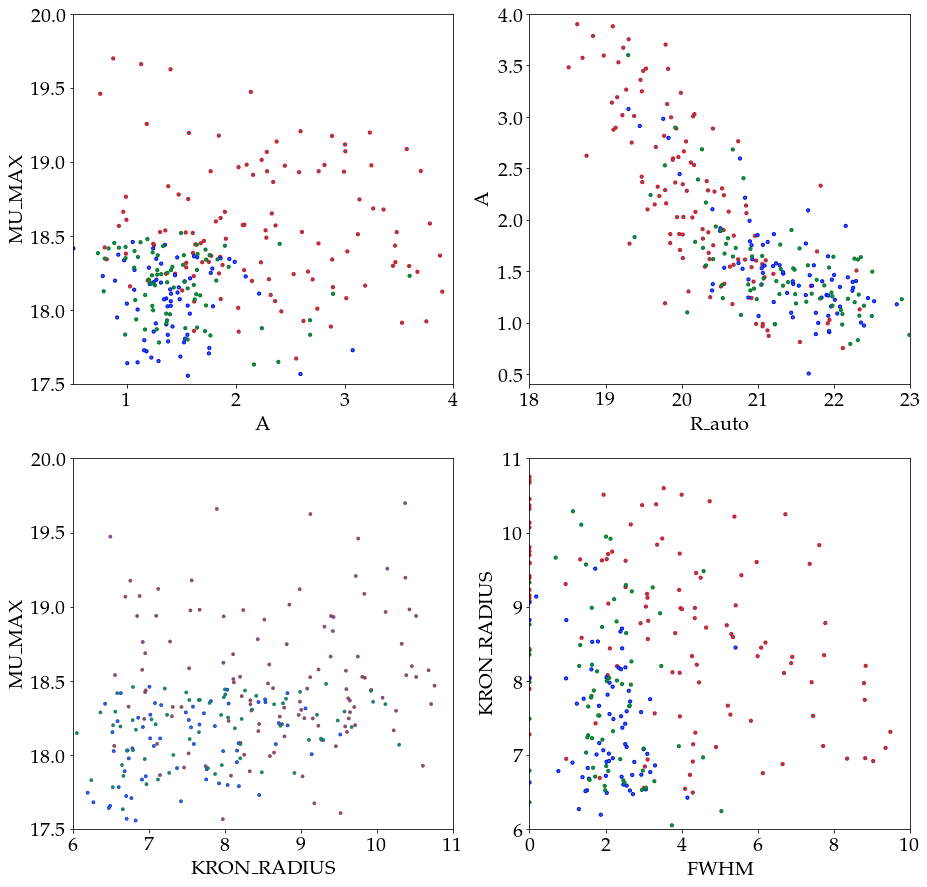

In [5]:
#plotting key physical parameters of the training and test samples to see if they provide a good separation.

fig = plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.scatter(A, MU_MAX, s=10, lw=1.0, ec=symbcolor)
plt.xlabel('A')
plt.ylabel('MU\_MAX')
plt.xlim(0.5,4)
plt.ylim(17.5, 20.0)

plt.subplot(2,2,2)
plt.scatter(r, A, s=10, lw=1.0, ec=symbcolor)
plt.xlabel('R\_auto')
plt.ylabel('A')
plt.xlim(18, 23.0)
plt.ylim(0.4,4)

plt.subplot(2,2,3)
plt.scatter(KRON_RADIUS, MU_MAX, s=10, lw=0.5, ec=symbcolor)
plt.xlabel('KRON\_RADIUS')
plt.ylabel('MU\_MAX')
plt.xlim(6.0, 11.0)
plt.ylim(17.5, 20.0)

plt.subplot(2,2,4)
plt.scatter(FWHM, KRON_RADIUS, s=10, lw=1.0, ec=symbcolor)
plt.xlabel('FWHM')
plt.ylabel('KRON\_RADIUS')
plt.xlim(0.0, 10.0)
plt.ylim(6.0, 11.0)

plt.savefig('properties_LSBs_red_nothing.png',bbox_inches='tight')

We applied the Gaussian Mixture Model technique to each of the physical parameters, allowing from 1 to 3 components. The idea is to identify which features are best to provide a separation between classes.

In [6]:
#Fitting each parameters with a Gaussian Mixture Model to check which of the parameters are better to detect more than one component (i.e., more than one type of galaxy)

from sklearn.mixture import GaussianMixture

def doGMM(X, x1, x2, xlabel,label, noiseStd=0.00000001):

    # fit models with 1-3 components
    N = np.arange(1, 4)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(X)

    # compute the BIC for each model
    BIC = [m.bic(X) for m in models]

    fig = plt.figure(figsize=(12, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)

    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(x1,x2, 1000)
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))

    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.hist(X, 'auto', density=True, histtype='stepfilled', alpha=0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('$p(x)$')

    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    ibest = np.argmin(BIC)
    plt.savefig('GMMresults_{}.png'.format(label),bbox_inches='tight')
    plt.show()

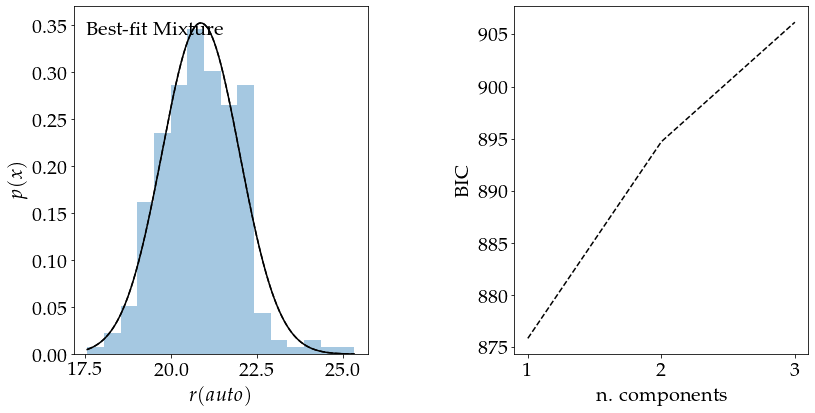

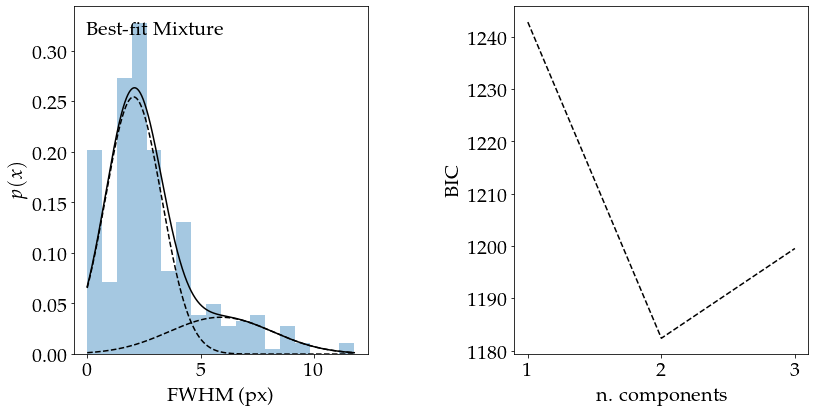

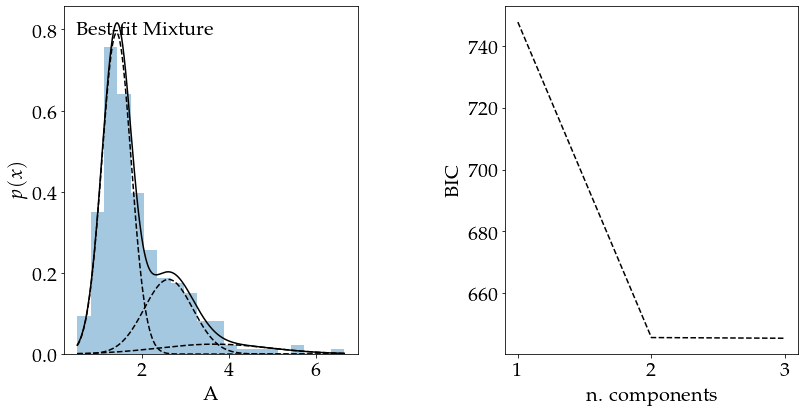

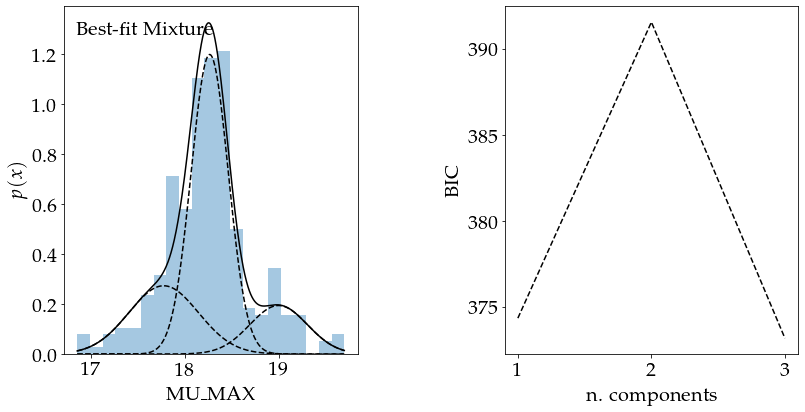

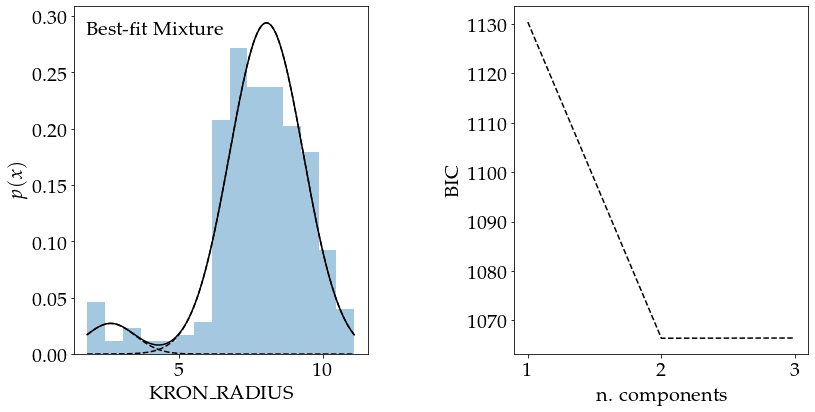

In [7]:
# To check which of these features can be well understood by the machine as having more than one component, we fitted a GMM to each of them. 

X1 = r.reshape(-1, 1)
X2 = FWHM.reshape(-1, 1)
X3 = A.reshape(-1, 1)
X4 = MU_MAX.reshape(-1, 1)
X5 = KRON_RADIUS.reshape(-1, 1)

doGMM(X1,x1=np.min(X1),x2=np.max(X1), xlabel="$r (auto)$",label='rauto')
doGMM(X2,x1=np.min(X2),x2=np.max(X2),xlabel="FWHM (px)",label='fwhm')
doGMM(X3,x1=np.min(X3),x2=np.max(X3),xlabel="A",label='A')
doGMM(X4,x1=np.min(X4),x2=np.max(X4),xlabel="MU\_MAX",label='mumax')
doGMM(X5,x1=np.min(X5),x2=np.max(X5),xlabel="KRON\_RADIUS",label='kronradius')

We can see that KRON_RADIUS, A, MU_MAX and FWHM are good features to train our classification method, because the machine is able to identify more than one component in their distributions. For the r-band magnitude, that is not the case though, and the data is better fitted by a single gaussian.
Particularly, we believe that the MU\_MAX and KRON\_RADIUS features are very promising classifiers to LSBGs, given that these galaxies are fainter and more extended than the other classes, and these features reflect that.
Based on all of the previous results, we decided to use four physical parameters to train our classification methods: KRON_RADIUS, MU_MAX, FWHM and A.

In [8]:
# Out of all features firstly selected, we choose to use only the ones that provide the best separation according to the previous plots, these are:
# Surface brightess (MU_MAX), Radius (KRON_RADIUS), and magnitude (R_auto and G_auto)
Ndim = 4 # numbers of features used, i.e. size of the parameter space
Ndata = len(labels) 
X = np.empty((Ndata, Ndim), dtype=float) # a matrix of zeros that will be filled with the data of the four features used
X[:Ndata, 0] = MU_MAX
X[:Ndata, 1] = A
if (Ndim > 2):
    X[:Ndata, 2] = KRON_RADIUS
    X[:Ndata, 3] = r

y = np.zeros(Ndata, dtype=int) # gathering the classification of the known objects
y[:Ndata] = labels
# set LSBs to 0, all others (high-redshift and nothing) to 1
y[y == 0] = 0
y[y != 0] = 1
# split into training and test sets.
#Here we separate 70% of the sample to training and only 30% to test, because we want the machine to learn the most it cans about the properties of LSBs.
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.7, 0.3], random_state=0) 

In [9]:
#Defining the GMM that will be used for the classification

from sklearn.mixture import GaussianMixture

class GMMBayes(GaussianNB):
    def __init__(self, n_components=1, **kwargs):
        self.n_components = np.atleast_1d(n_components)
        self.kwargs = kwargs

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples, n_features = X.shape

        if n_samples != y.shape[0]:
            raise ValueError("X and y have incompatible shapes")

        self.classes_ = np.unique(y)
        self.classes_.sort()
        unique_y = self.classes_

        n_classes = unique_y.shape[0]

        if self.n_components.size not in (1, len(unique_y)):
            raise ValueError("n_components must be compatible with "
                             "the number of classes")

        self.gmms_ = [None for i in range(n_classes)]
        self.class_prior_ = np.zeros(n_classes)

        n_comp = np.zeros(len(self.classes_), dtype=int) + self.n_components

        for i, y_i in enumerate(unique_y):
            if n_comp[i] > X[y == y_i].shape[0]:
                warnstr = ("Expected n_samples >= n_components but got "
                           "n_samples={0}, n_components={1}, "
                           "n_components set to {0}.")
                warnings.warn(warnstr.format(X[y == y_i].shape[0], n_comp[i]))
                n_comp[i] = y_i
            self.gmms_[i] = GaussianMixture(n_comp[i], **self.kwargs).fit(X[y == y_i])
            self.class_prior_[i] = np.float(np.sum(y == y_i)) / n_samples

        return self

    def _joint_log_likelihood(self, X):

        X = np.asarray(np.atleast_2d(X))
        logprobs = np.array([g.score_samples(X) for g in self.gmms_]).T
        return logprobs + np.log(self.class_prior_)

In [10]:
# Classify training and test samples with each classifier
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        model = classifier(**kwargs) # training subsample
        model.fit(X_train, y_train) # testing subsample 
        y_prob = model.predict_proba(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LSBclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (QDA, {}),
                               (LogisticRegression,
                                dict(class_weight=LSBclass_weight)),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3, tol=1E-5,
                                               covariance_type='full')))

/home/luisabuzzo/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/luisabuzzo/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


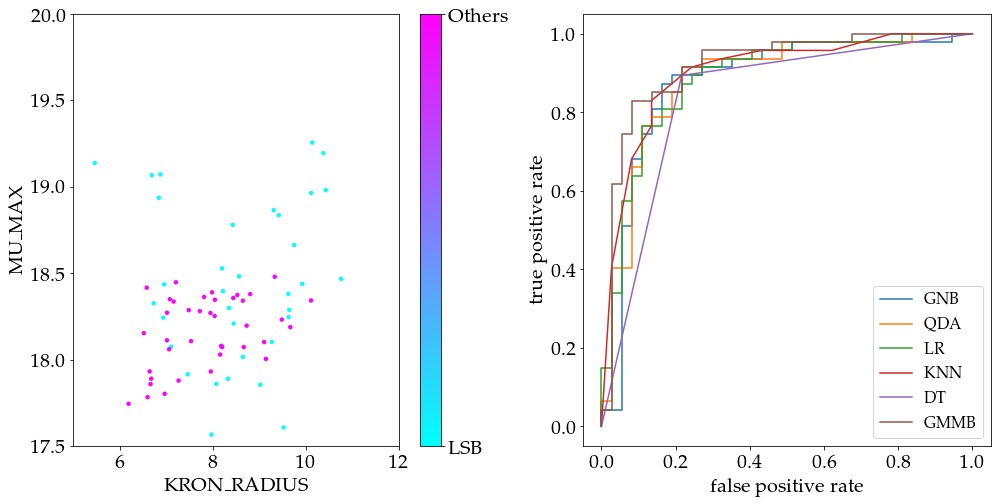

In [11]:
# Plot results
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# Projection of the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 2], X_test[:, 0], c=y_test, s=20,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.cool)
cbar = fig.colorbar(im, ticks=[0, 1])
cbar.ax.set_yticklabels(['LSB','Others'])  # vertically oriented colorbar
# im.set_clim(0, 1)
ax1.set_xlim(5, 12)
# ax1.set_xticks([-1.5,-0.5,0.5,1.5])
ax1.set_ylim(17.5,20)
ax1.set_xlabel('KRON\_RADIUS')
ax1.set_ylabel('MU\_MAX')

labels = dict(GaussianNB='GNB',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

# ROC curves
ax2 = fig.add_subplot(122)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    ax2.plot(fpr, tpr, label=labels[name])

ax2.legend(loc=4,fontsize=16)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
plt.savefig('firsttest_LSBs_newsample_LSBs_red.png',bbox_inches='tight')

plt.show()

In [12]:
data_test = Table.read('./SPLUS-s27s34_objects.csv',format='csv') # import the data that will be splitted in training and test samples.
# key physical parameters that will be used as features since they separatr well the objects. 
#From those, we pay a special attention to the magnitudes, surface brightness and kron_radius, since LSBs are generally fainter than other galaxies and larger in radii.
# The KRON_RADIUS, defined as the first moment of the surface brightness light profile is strongly correlated with redshift and thus may provide a good difference among sources.
Ndata = len(data_test)
Ndim=4
X_new = np.empty((Ndata, Ndim), dtype=float) # a matrix of zeros that will be filled with the data of the four features used
X_new[:Ndata, 0] = data_test['MU_MAX']
X_new[:Ndata, 1] = data_test['A']
if (Ndim > 2):
    X_new[:Ndata, 2] = data_test['KRON_RADIUS']
    X_new[:Ndata, 3] = data_test['r_auto']

def compute_results(*args):
    names_new = []
    probs_new = []

    for classifier, kwargs in args:
        model = classifier(**kwargs) # training subsample
        model.fit(X_train, y_train) # note that we are using the data we want to classify
        y_prob_new = model.predict_proba(X_new)
        names_new.append(classifier.__name__)
        probs_new.append(y_prob_new[:, :])

    return names_new, probs_new

LSBclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names_new, probs_new = compute_results((GaussianNB, {}),
                               (QDA, {}),
                               (LogisticRegression,
                                dict(class_weight=LSBclass_weight)),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3, tol=1E-5,
                                               covariance_type='full')))

Class_res = []
Probs_res = []

for i in probs_new: #looking at each classifier
    Class = []
    probs_LSBs = []
    for j in i: # looping over each object to see if the probability is higher of being an LSB or not.
        probs_LSBs.append(j[0])
        if j[0]>j[1]: # if prob(LSB)>prob(non-LSB)
            Class.append(0) #LSB
        else:
            Class.append(1) #non-LSB
    Class_res.append(Class)
    Probs_res.append(probs_LSBs)

classification = np.array(Class_res[3]) #[3]:KNN -> choosing KNN as the best because of the ROC curve results
probabilities = np.array(Probs_res[3])
data_class = data_test[probabilities>0.8] # selecting only objects with probability of being an LSBGs higher than 0.8
print('This field has {} objects that have a probability higher than 0.8 of being LSBs.'.format(len(data_class)))
data_class.write('LSBs_found_SPLUS-s27s34_prob0.8.csv',format='csv',overwrite=True) #save table with objects with high probabilities

This field has 124 objects that have a probability higher than 0.8 of being LSBs.


/home/luisabuzzo/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/luisabuzzo/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


/home/luisabuzzo/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Use the colorbar set_ticks() method instead.
/home/luisabuzzo/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Use the colorbar set_ticks() method instead.
/home/luisabuzzo/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


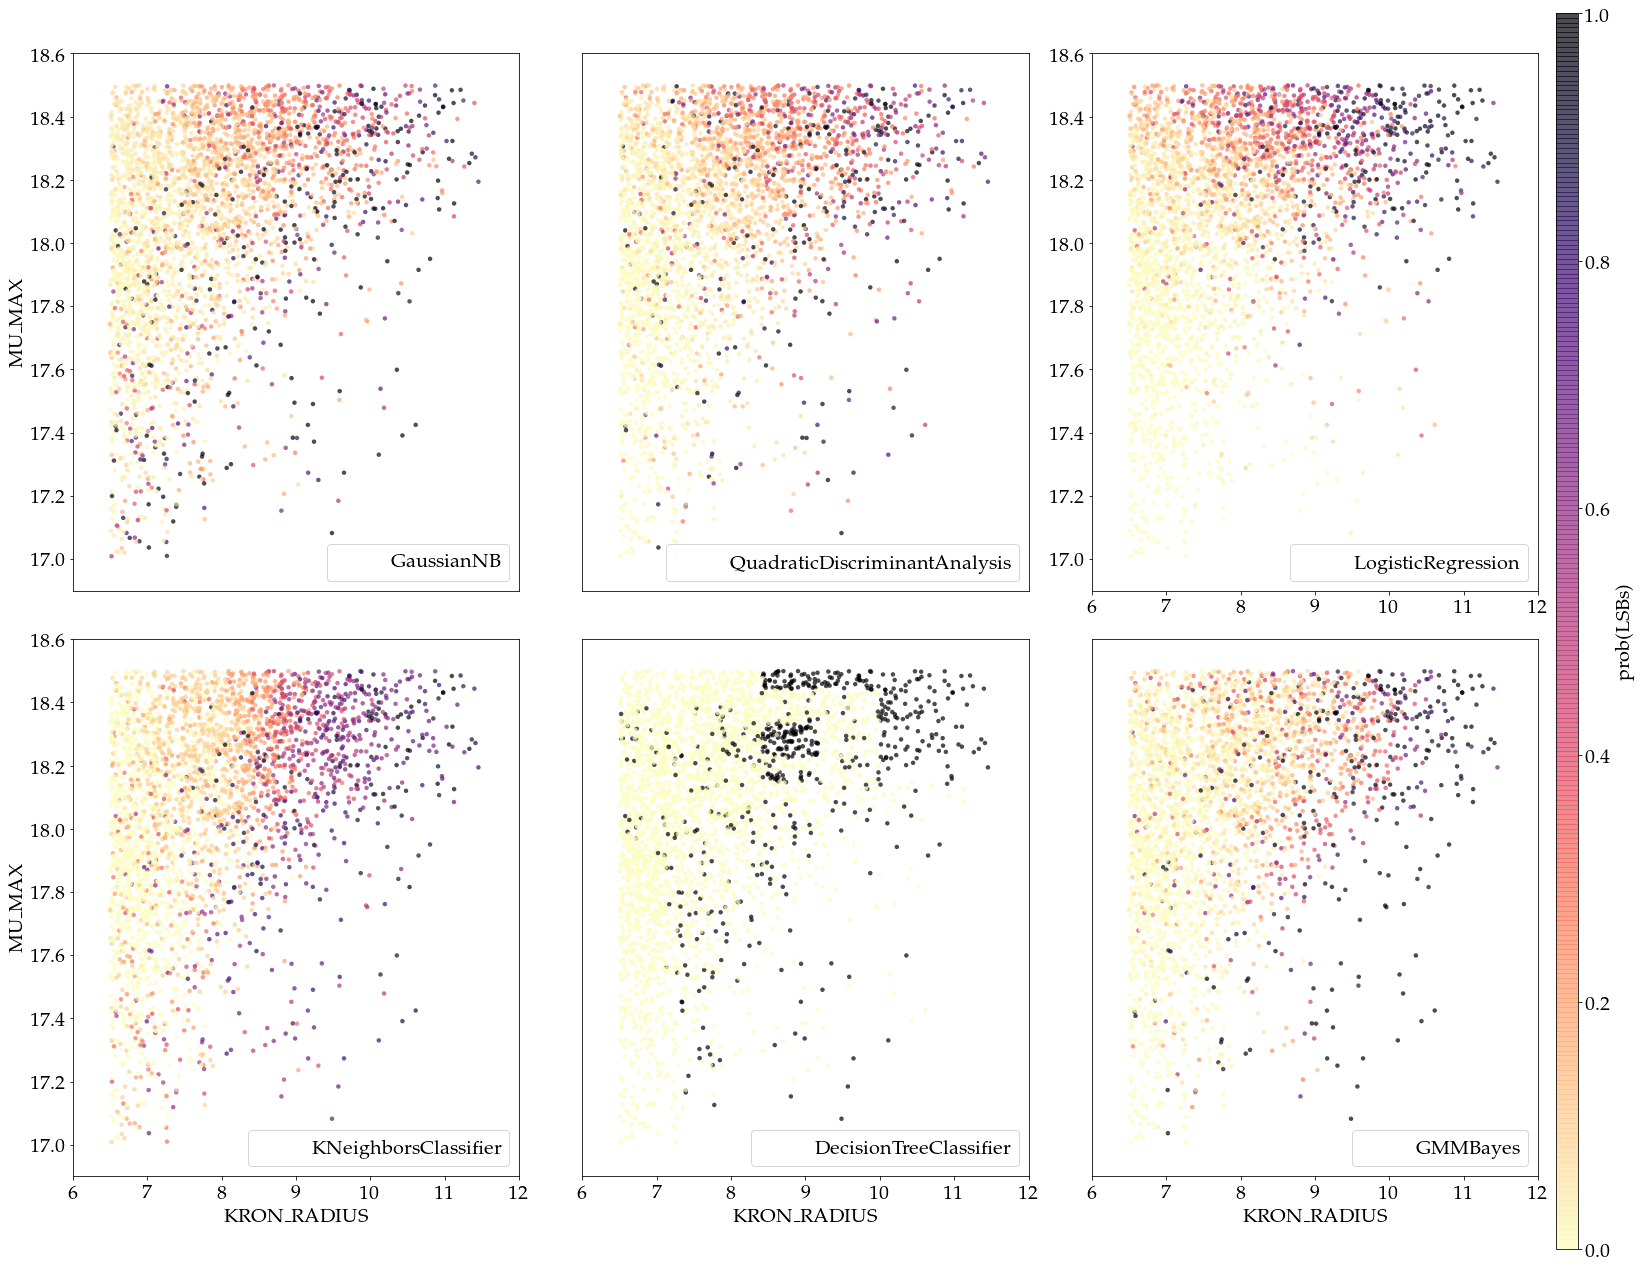

In [13]:
# Plot results
# After applying our methods, we verify the probability that each object is labelled as an LSBG, for each method.

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)
ax1 = fig.add_subplot(231)
im = ax1.scatter(X_new[:, 2], X_new[:, 0], c=Probs_res[0],vmin=0,vmax=1, s=20,
                 linewidths=0, cmap=plt.cm.magma_r,alpha=0.7,label='{}'.format(names_new[0]))
plt.legend(markerscale=0)
ax1.set_xlim(6, 12)
ax1.set_ylim(16.9,18.6)
plt.xticks([])
ax1.set_ylabel('MU\_MAX')

ax2 = fig.add_subplot(232)
im = ax2.scatter(X_new[:, 2], X_new[:, 0], c=Probs_res[1],vmin=0,vmax=1, s=20,
                 linewidths=0, cmap=plt.cm.magma_r,alpha=0.7,label='{}'.format(names_new[1]))
plt.legend(markerscale=0)
ax2.set_xlim(6, 12)
ax2.set_ylim(16.9,18.6)
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(233)
im = ax3.scatter(X_new[:, 2], X_new[:, 0], c=Probs_res[2],vmin=0,vmax=1, s=20,
                 linewidths=0, cmap=plt.cm.magma_r,alpha=0.7,label='{}'.format(names_new[2]))
plt.legend(markerscale=0)
ax3.set_xlim(6, 12)
ax3.set_ylim(16.9,18.6)
axins = inset_axes(ax3,
                    width="5%",  
                    height="230%",
                    loc='upper right',
                   borderpad=-2
                   )
fig.colorbar(im, cax=axins,label='prob(LSBs)')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_subplot(234)
im = ax4.scatter(X_new[:, 2], X_new[:, 0], c=Probs_res[3],vmin=0,vmax=1, s=20,
                 linewidths=0, cmap=plt.cm.magma_r,alpha=0.7,label='{}'.format(names_new[3]))
plt.legend(markerscale=0)
ax4.set_xlim(6, 12)
ax4.set_ylim(16.9,18.6)
ax4.set_xlabel('KRON\_RADIUS')
ax4.set_ylabel('MU\_MAX')

ax5 = fig.add_subplot(235)
im = ax5.scatter(X_new[:, 2], X_new[:, 0], c=Probs_res[4],vmin=0,vmax=1, s=20,
                 linewidths=0, cmap=plt.cm.magma_r,alpha=0.7,label='{}'.format(names_new[4]))
plt.legend(markerscale=0)
ax5.set_xlim(6, 12)
ax5.set_ylim(16.9,18.6)
plt.yticks([])
ax5.set_xlabel('KRON\_RADIUS')

ax6 = fig.add_subplot(236)
im = ax6.scatter(X_new[:, 2], X_new[:, 0], c=Probs_res[5],vmin=0,vmax=1, s=20,
                 linewidths=0, cmap=plt.cm.magma_r,alpha=0.7,label='{}'.format(names_new[5]))
plt.legend(markerscale=0)
ax6.set_xlim(6, 12)
ax6.set_ylim(16.9,18.6)
plt.yticks([])
ax6.set_xlabel('KRON\_RADIUS')

# ax1.set_ylabel('MU\_MAX')
fig.tight_layout()
plt.savefig('LSBs_probs_SPLUS-s28s34.png',bbox_inches='tight')

plt.show()

We can see that the classification with the decision tree method is not working well. However, all the others show a sensible distribution, revealing that the objects with highest probabilities of being LSBGs are the ones with highest KRON_RADIUS, while objects with smaller MU_MAX and KRON_RADIUS have very small probabilities of being LSBGs.

# Conclusion

In this work, we have applied machine learning classification techniques to systematically find low surface brightness galaxies within the S-PLUS survey. Using key features of LSBGs such as surface brightness and radius, we were able to separate objects in two classes: LSBGs or non-LSBGs. The initial sample contained 122 LSBGs and 120 non-LSBGs, further split into training (70\%) and test (30\%) samples. We report that the best classification was provided by the KNN method, even though the GNB,GMMB,LR and QDA methods also provided good results. We then applied the technique to find LSBGs in the central tile of the Fornax cluster, SPLUS-s27s34. We found 35 new LSBG amongst the 124 candidates with probability higher than 0.8. 

Our method was impacted by the quite modest total number of known LSBGs to train and test the classifiers. Nevertheless, we still find very promising results, leading to hundreds of new LSBG candidates in SPLUS, helping to overcome the difficulties implied by a shallow depth.  

Increasing the number of LSBGs in the training sample has the potential of providing even better classification and potentially lead to catalogs of thousands of LSBGs within the survey.
As additional future perspectives, we intend to apply this classification to the entire S-PLUS iDR3, finding LSBGs at different distances and environments. We will iteratively add the new LSBGs found to the training samples to increase and improve our classification and find even more objects. 

We note that this work is extendable to any multi-band survey, such as J-PLUS in the Northern hemisphere or even the Vera Rubin Telescope, which may provide an unprecedented map of LSBGs given to its high depth and sky coverage.